In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.api import VAR
import matplotlib.ticker as mticker
from collections import Counter
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

In [2]:
# --- Last inn data ---
url = "https://raw.githubusercontent.com/jensmorten/onesixtynine/main/data/pollofpolls_master.csv"
df = pd.read_csv(url, index_col="Mnd", parse_dates=True)
df = df.sort_index()
df.index = df.index.to_period('M').to_timestamp('M')  # månadsslutt

In [3]:
# --- Map kolonnenamn til nynorsk ---
kolonne_map = {
    'Hoyre': 'Høgre',
    'Rodt': 'Raudt',
    'SP': 'Sp'
}
df = df.rename(columns=kolonne_map)

In [4]:
def hybrid_var_ml_forecast_regime_gated(
    df,
    n_months,
    var_lags,
    lags_ML,
    tau=3.0,
    vol_window=6,
    min_alpha=0.0,
    max_alpha=1.0
):
    """
    Hybrid VAR + ML with:
      - adaptive α per party
      - regime gating based on volatility ratio
      - horizon decay

    Regime strength = recent_vol / long_run_vol
    """

    model = VAR(df)
    var_res = model.fit(maxlags=var_lags, method="ols", trend="n")

    mean_var, lower_var, upper_var = var_res.forecast_interval(
        var_res.endog, steps=n_months
    )

    # VAR residuals (in-sample)
    fitted = var_res.fittedvalues
    true = df.iloc[var_res.k_ar:]
    resid = true.values - fitted.values

    # Build ML dataset
    X, y = [], []
    for i in range(lags_ML, len(df)):
        if i - var_res.k_ar < 0:
            continue
        X.append(df.iloc[i-lags_ML:i].values.flatten())
        y.append(resid[i - var_res.k_ar])

    X = np.asarray(X)
    y = np.asarray(y)

    n_parties = df.shape[1]
    ml_resid_forecast = np.zeros((n_months, n_parties))

    if len(X) < 100:
        return mean_var, lower_var, upper_var

    # Pre-compute volatility regime indicators
    ddf = df.diff()

    recent_vol = (
        ddf.iloc[-vol_window:]
        .abs()
        .mean(axis=0)
        .values
    )

    long_run_vol = (
        ddf.abs()
        .mean(axis=0)
        .values
        + 1e-8
    )

    regime_strength = recent_vol / long_run_vol  # per party

    for j in range(n_parties):
        yj = y[:, j]

        # --- ML model ---
        model_ml = LGBMRegressor(
            n_estimators=500,
            num_leaves=16,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=123,
            verbose=-1
        )
        model_ml.fit(X, yj)

        # --- adaptive α (in-sample calibration) ---
        y_hat_train = model_ml.predict(X)

        num = np.dot(yj, y_hat_train)
        den = np.dot(y_hat_train, y_hat_train) + 1e-8
        alpha_j = num / den
        alpha_j = float(np.clip(alpha_j, min_alpha, max_alpha))

        # --- regime-gated weight ---
        rs = regime_strength[j]

        if rs < 0.8:
            regime_weight = 0.0         # calm regime → VAR only
        elif rs < 1.2:
            regime_weight = (rs - 0.8) / (1.2 - 0.8)  # linear ramp [0,1]
        else:
            regime_weight = 1.0         # regime change

        # --- forecasting ---
        win = df.values[-lags_ML:].copy()

        for t in range(n_months):
            r_raw = model_ml.predict(win.reshape(1, -1))[0]

            if tau is not None:
                time_decay = np.exp(-t / tau)
            else:
                time_decay = 1.0

            r = alpha_j * regime_weight * time_decay * r_raw

            ml_resid_forecast[t, j] = r

            # IMPORTANT: no feedback of corrected forecast
            win = np.vstack([win[1:], mean_var[t]])

    forecast = mean_var + ml_resid_forecast
    lower = lower_var + ml_resid_forecast
    upper = upper_var + ml_resid_forecast

    return forecast, lower, upper


In [5]:
forecast, forecast_lower, forecast_upper = hybrid_var_ml_forecast(
            df=df,
            n_months=6,
            var_lags=4,
            lags_ML=12
)

NameError: name 'hybrid_var_ml_forecast' is not defined

In [9]:
import pandas as pd
import numpy as np

def compute_regime_timeline(df, party, vol_window=6):
    """
    Returns a DataFrame with:
      - level
      - abs monthly change
      - recent volatility
      - long-run volatility
      - regime strength
      - regime weight (0–1)
    """

    s = df[party]
    d = s.diff()

    long_run_vol = d.abs().mean()

    recent_vol = d.abs().rolling(vol_window).mean()
    regime_strength = recent_vol / (long_run_vol + 1e-8)

    # Same gating logic as model
    def regime_weight(rs):
        if rs < 0.8:
            return 0.0
        elif rs < 1.2:
            return (rs - 0.8) / (1.2 - 0.8)
        else:
            return 1.0

    weight = regime_strength.apply(regime_weight)

    return pd.DataFrame({
        "level": s,
        "abs_change": d.abs(),
        "recent_vol": recent_vol,
        "regime_strength": regime_strength,
        "regime_weight": weight
    })


In [10]:
import matplotlib.pyplot as plt

def plot_regime_timeline(df, party, vol_window=6):
    out = compute_regime_timeline(df, party, vol_window)

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # 1. Level
    axs[0].plot(out.index, out["level"], label=party)
    axs[0].set_title(f"{party} – Level")
    axs[0].grid(True)

    # 2. Regime strength
    axs[1].plot(out.index, out["regime_strength"], color="orange")
    axs[1].axhline(0.8, linestyle="--", color="gray")
    axs[1].axhline(1.2, linestyle="--", color="gray")
    axs[1].set_title("Regime strength (recent vol / long-run vol)")
    axs[1].grid(True)

    # 3. ML activation weight
    axs[2].fill_between(
        out.index,
        0,
        out["regime_weight"],
        alpha=0.5
    )
    axs[2].set_ylim(0, 1)
    axs[2].set_title("ML regime weight (α multiplier)")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


In [12]:
%matplotlib inline

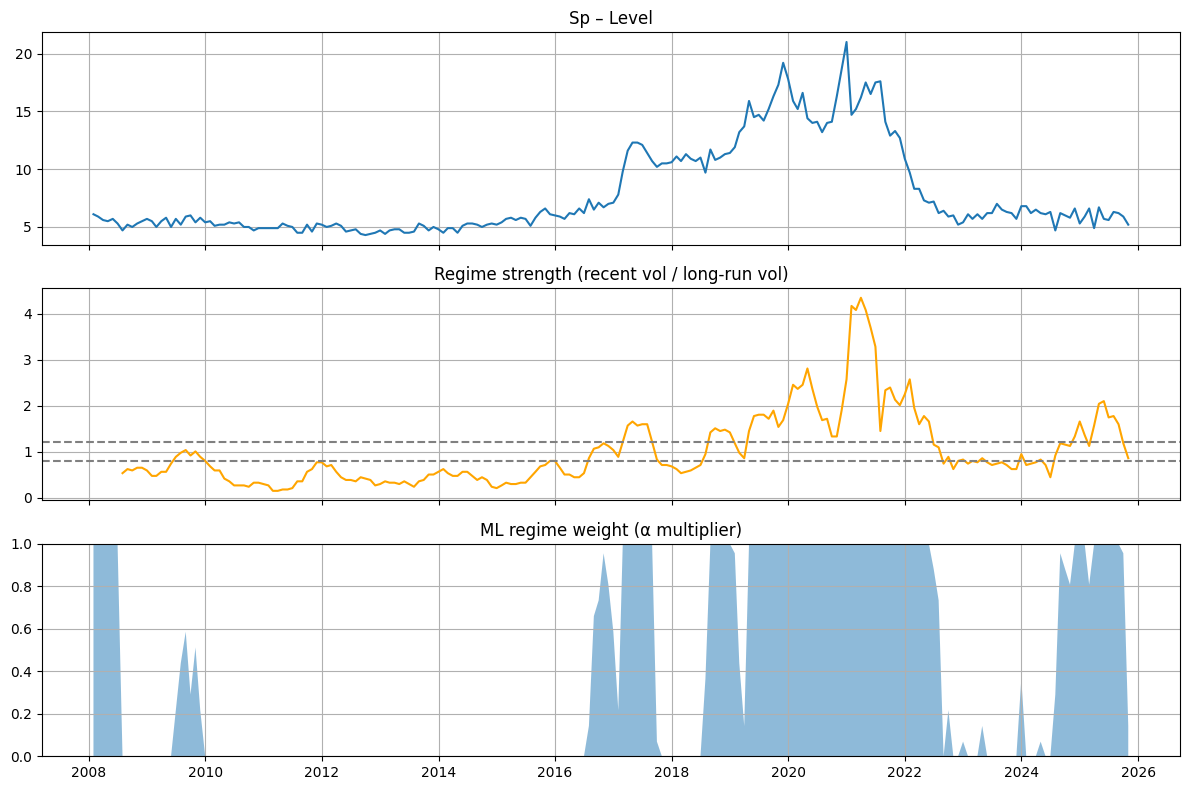

In [16]:
plot_regime_timeline(df, "Sp")
#plot_regime_timeline(df, "Raudt")
#plot_regime_timeline(df, "Sp")

In [90]:
n_months = 3
train = df.iloc[:-n_months]
test  = df.iloc[-n_months:]

# VAR-only
var_fc = var_only_forecast(train, n_months=n_months, var_lags=4)

# Adaptive hybrid
hyb_fc, _, _ = hybrid_var_ml_forecast_adaptive(
    train, n_months=n_months, var_lags=4, lags_ML=12, tau=3
)

rows = []
for i, party in enumerate(df.columns):
    y_true = test.iloc[:, i].values

    mae_var = mean_absolute_error(y_true, var_fc[:, i])
    mae_hyb = mean_absolute_error(y_true, hyb_fc[:, i])

    rows.append({
        "party": party,
        "VAR_MAE": mae_var,
        "Hybrid_MAE": mae_hyb,
        "Delta": mae_hyb - mae_var
    })

perf_adaptive = pd.DataFrame(rows).sort_values("Delta")
perf_adaptive


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\

,party,VAR_MAE,Hybrid_MAE,Delta
2,Frp,2.540009,2.357030,-0.182979
0,Ap,0.467009,0.297071,-0.169938
8,Raudt,0.539782,0.371489,-0.168293
1,Høgre,1.634137,1.515004,-0.119132
6,Venstre,0.705691,0.667533,-0.038157
3,SV,2.441341,2.445928,0.004586
7,MDG,1.939295,1.945856,0.006562
5,KrF,0.844297,0.903951,0.059654
4,Sp,0.437623,0.533070,0.095447
9,Andre,0.426338,0.565245,0.138907


In [89]:
import matplotlib.pyplot as plt

plt.scatter(
    rolling_results["recent_vol"],
    rolling_results["Delta"],
    alpha=0.4
)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Recent volatility")
plt.ylabel("Hybrid − VAR MAE")
plt.title("ML helps mainly in high-volatility regimes")
plt.show()


KeyError: 'recent_vol'

In [80]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

def rolling_backtest(
    df,
    start_train_size,
    n_months,
    var_lags,
    lags_ML,
    step=1,
    tau=2.0
):
    """
    Rolling-origin evaluation for VAR vs adaptive hybrid.
    Returns per-party aggregated MAE and deltas.
    """

    results = []

    for end in range(start_train_size, len(df) - n_months + 1, step):
        train = df.iloc[:end]
        test  = df.iloc[end:end + n_months]

        # VAR-only
        var_fc = var_only_forecast(
            train,
            n_months=n_months,
            var_lags=var_lags
        )

        # Adaptive hybrid
        hyb_fc, _, _ = hybrid_var_ml_forecast_adaptive(
            train,
            n_months=n_months,
            var_lags=var_lags,
            lags_ML=lags_ML,
            tau=tau
        )

        for i, party in enumerate(df.columns):
            y_true = test.iloc[:, i].values

            results.append({
                "party": party,
                "VAR_MAE": mean_absolute_error(y_true, var_fc[:, i]),
                "Hybrid_MAE": mean_absolute_error(y_true, hyb_fc[:, i]),
                "Delta": mean_absolute_error(y_true, hyb_fc[:, i])
                         - mean_absolute_error(y_true, var_fc[:, i])
            })

    return pd.DataFrame(results)


In [81]:
rolling_results = rolling_backtest(
    df,
    start_train_size=60,   # e.g. first 5 years monthly
    n_months=3,
    var_lags=4,
    lags_ML=12,
    step=1,                # move one month forward
    tau=2.0
)


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\

In [82]:
summary = (
    rolling_results
    .groupby("party")
    .agg(
        VAR_MAE=("VAR_MAE", "mean"),
        Hybrid_MAE=("Hybrid_MAE", "mean"),
        Delta=("Delta", "mean"),
        WinRate=("Delta", lambda x: (x < 0).mean())
    )
    .sort_values("Delta")
)

summary

,VAR_MAE,Hybrid_MAE,Delta,WinRate
party,,,,
Ap,2.348506,2.344134,-0.004372,0.289474
Raudt,0.617620,0.613950,-0.003670,0.355263
Frp,1.939058,1.935567,-0.003491,0.328947
Sp,1.187334,1.184519,-0.002815,0.315789
Andre,0.467155,0.464577,-0.002578,0.381579
Høgre,2.314396,2.311884,-0.002512,0.381579
Venstre,0.513462,0.511316,-0.002145,0.348684
SV,0.657765,0.656639,-0.001126,0.335526
KrF,0.390242,0.389664,-0.000578,0.328947


In [83]:
(
    rolling_results
    .groupby("party")["Delta"]
    .quantile([0.1, 0.5, 0.9])
    .unstack()
    .rename(columns={0.1:"p10", 0.5:"median", 0.9:"p90"})
)


,p10,median,p90
party,,,
Andre,-0.034534,0.0,0.025311
Ap,-0.135652,0.0,0.098906
Frp,-0.084084,0.0,0.064665
Høgre,-0.085939,0.0,0.066684
KrF,-0.028596,0.0,0.029400
MDG,-0.019624,0.0,0.025399
Raudt,-0.037954,0.0,0.028074
SV,-0.048318,0.0,0.041803
Sp,-0.068214,0.0,0.052924


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def backtest_per_party(
    df,
    n_months,
    var_lags,
    lags_ML,
    metrics=("MAE", "RMSE", "MAPE")
):
    train = df.iloc[:-n_months]
    test = df.iloc[-n_months:]

    forecast, _, _ = hybrid_var_ml_forecast(
        train,
        n_months=n_months,
        var_lags=var_lags,
        lags_ML=lags_ML
    )

    results = {}

    for i, party in enumerate(df.columns):
        y_true = test.iloc[:, i].values
        y_pred = forecast[:, i]

        party_res = {}

        if "MAE" in metrics:
            party_res["MAE"] = mean_absolute_error(y_true, y_pred)

        if "RMSE" in metrics:
            party_res["RMSE"] = np.sqrt(
                mean_squared_error(y_true, y_pred)
            )

        if "MAPE" in metrics:
            party_res["MAPE"] = np.mean(
                np.abs((y_true - y_pred) / y_true)
            )

        results[party] = party_res

    return pd.DataFrame(results).T


In [70]:
perf_per_party = backtest_per_party(
    df,
    n_months=3,
    var_lags=4,
    lags_ML=12
)

print(perf_per_party.sort_values("MAPE"))


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\

              MAE      RMSE      MAPE
Ap       0.326943  0.384001  0.011980
Raudt    0.128752  0.165965  0.021101
Frp      2.331110  2.891470  0.101618
Høgre    1.511744  1.823757  0.102615
Sp       0.647646  0.801422  0.116512
Venstre  0.633897  0.663240  0.157538
Andre    0.799613  0.817627  0.185311
KrF      0.985451  1.000596  0.217600
MDG      1.916098  2.101925  0.366365
SV       2.440976  2.451594  0.405714


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [71]:
perf_per_party = backtest_per_party(
    df,
    n_months=6,
    var_lags=4,
    lags_ML=12
)

perf_per_party.sort_values("MAPE")

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\

,MAE,RMSE,MAPE
SV,0.547474,0.895331,0.073310
Ap,3.282779,3.433190,0.118812
KrF,0.629935,0.718829,0.150344
Andre,0.679332,0.725323,0.158155
Venstre,0.694962,0.757604,0.158982
MDG,0.956213,1.301101,0.202370
Frp,5.857710,6.418429,0.267461
Raudt,1.639571,1.749142,0.270856
Høgre,4.980757,5.308285,0.327177
Sp,1.929712,2.176731,0.340142


In [72]:
def var_only_forecast(df, n_months, var_lags):
    model = VAR(df)
    res = model.fit(maxlags=var_lags, trend="n")
    mean, _, _ = res.forecast_interval(res.endog, steps=n_months)
    return mean


In [73]:
n_months = 6

train = df.iloc[:-n_months]
test  = df.iloc[-n_months:]

In [74]:
var_fc = var_only_forecast(train, n_months=n_months, var_lags=4)
hyb_fc, _, _ = hybrid_var_ml_forecast(train, n_months, 4, 12)

rows = []
for i, party in enumerate(df.columns):
    rows.append({
        "party": party,
        "VAR_MAE": mean_absolute_error(test.iloc[:, i], var_fc[:, i]),
        "Hybrid_MAE": mean_absolute_error(test.iloc[:, i], hyb_fc[:, i]),
        "Delta": mean_absolute_error(test.iloc[:, i], hyb_fc[:, i]) -
                 mean_absolute_error(test.iloc[:, i], var_fc[:, i])
    })

pd.DataFrame(rows).sort_values("Delta")


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\utils\

,party,VAR_MAE,Hybrid_MAE,Delta
8,Raudt,1.905501,1.639571,-0.265930
3,SV,0.553893,0.547474,-0.006419
2,Frp,5.824279,5.857710,0.033432
7,MDG,0.898875,0.956213,0.057338
4,Sp,1.859498,1.929712,0.070214
5,KrF,0.472213,0.629935,0.157722
1,Høgre,4.815953,4.980757,0.164805
6,Venstre,0.501968,0.694962,0.192995
9,Andre,0.467150,0.679332,0.212182
0,Ap,2.812339,3.282779,0.470439


In [30]:
n_months=6
months_back=48
forecast_index = pd.date_range(start=df.index[-1], periods=n_months+1, freq='M')[1:]

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df.columns)
forecast_df = forecast_df.div(forecast_df.sum(axis=1), axis=0) * 100
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index, columns=df.columns)
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index, columns=df.columns)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_14236\3748058168.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=n_months+1, freq='M')[1:]


In [31]:
# --- Formatering av datoar ---

colors = {
    'Ap': '#FF6666', 'Høgre': '#6699FF', 'Frp': '#3366CC', 'SV': '#FF9999',
    'Sp': '#339966', 'KrF': '#FFCC66', 'Venstre': '#99CCFF',
    'MDG': '#33CC33', 'Raudt': '#CC3333', 'Andre': '#AAAAAA'
}
# --- Juster data for plotting ---
df_recent = df.iloc[-months_back:]
df_recent_eom = df_recent.copy()
df_recent_eom.index = df_recent_eom.index + MonthEnd(0)

forecast_df_eom = forecast_df.copy()
forecast_df_eom.index = forecast_df_eom.index + MonthEnd(0)
forecast_lower_df_eom = forecast_lower_df.copy()
forecast_lower_df_eom.index = forecast_lower_df_eom.index + MonthEnd(0)
forecast_upper_df_eom = forecast_upper_df.copy()
forecast_upper_df_eom.index = forecast_upper_df_eom.index + MonthEnd(0)

In [91]:
# --- Define colors for consistency ---
colors = {
    'Ap': '#FF0000',        # Red
    'Høgre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Raudt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


# --- Plot ---
plt.figure(figsize=(14, 7))

months_back = 12
df_recent = df.iloc[-months_back:]  # last 12 months actual

for party, color in colors.items():

    # Actual observed data
    plt.plot(
        df_recent.index,
        df_recent[party],
        marker="o",
        color=color,
        label=f"{party}"
    )

    # Forecast line (bootstrap mean)
    plt.plot(
        forecast_df.index,
        forecast_df[party],
        linestyle="dashed",
        color=color
    )

    # Connect last actual point to first forecast
    plt.plot(
        [df_recent.index[-1], forecast_df.index[0]],
        [df_recent[party].iloc[-1], forecast_df[party].iloc[0]],
        linestyle="dashed",
        color=color
    )

    # Confidence interval (bootstrap)
    plt.fill_between(
        forecast_df.index,
        forecast_lower_df[party],
        forecast_upper_df[party],
        color=color,
        alpha=0.15
    )

# --- Vertical monthly guides ---
dates = pd.date_range(start=df_recent.index[0], end=forecast_df.index[-1], freq="MS")
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.3)

# --- Horizontal percentage lines ---
for percent in range(0, 45, 5):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.3)

# --- Final formatting ---
plt.xlim(df_recent.index[0], forecast_df.index[-1])
plt.ylim(0, 40)
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine")
plt.legend(loc="upper left", ncol=2)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_14236\3949232073.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
